### CryoParticleSegment

In [ ]:
#%%bash
#git clone git+https://cyanazuki@github.com/cyanazuki/CryoParticleSegment.git
#cd CryoParticleSegment
#python setup.py install

In [ ]:
%pip install torchinfo -qq
%pip install -U git+https://github.com/qubvel/segmentation_models.pytorch -qq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 37.0 MB/s eta 0:00:00


## ⭐ Setup
You must run all codes under this category.

### ✅ Directory Settings

In [ ]:
# @title  { display-mode: "form" }

IMAGE_DIR = "/content/drive/MyDrive/research_xs/dataset/10081/processed_micrographs_np_split" # @param {type:"string"}
LABEL_DIR = "/content/drive/MyDrive/research_xs/dataset/10081/micrographs_ground_np" # @param {type:"string"}
RESULT_DIR = "/content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf" # @param {type:"string"}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title  { display-mode: "form" }
# @markdown Detect whether using folder in Google Drive as **`RESULT DIR`**📁.

if "content" in IMAGE_DIR.split("/")[:3] or "content" in LABEL_DIR.split("/")[:3]:
  try:
    from google.colab import drive
    drive.mount('/content/drive')
    !rm -r /content/sample_data
    if "content" in IMAGE_DIR.split("/")[:3]:
      !cp -r {IMAGE_DIR} /content/image_dir
      IMAGE_DIR = "/content/image_dir"
    if "content" in LABEL_DIR.split("/")[:3]:
      !cp -r {LABEL_DIR} /content/label_dir
      LABEL_DIR = "/content/label_dir"
  except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGE_DIR = "/content/image_dir"

In [ ]:
# @title  { display-mode: "form" }
# @markdown Source code directory.
SRC_DIR = "/content/drive/MyDrive/00_Image\ meeting/Researches/01_Scratchpad/seg_src/CryoParticleSegment-main/Modeling" # @param {type:"string"}

if True:
  !cp -rf {SRC_DIR}/* /content/
else:
  !cp {SRC_DIR}/convcrf.py /content/convcrf.py
  !cp {SRC_DIR}/dataset.py /content/dataset.py
  !cp {SRC_DIR}/lr_scheduler.py /content/lr_scheduler.py
  !cp {SRC_DIR}/metrics.py /content/metrics.py
  !cp {SRC_DIR}/model.py /content/model.py
  !cp {SRC_DIR}/trainer.py /content/trainer.py
  !cp {SRC_DIR}/utils.py /content/utils.py

In [ ]:
%git clone https://github.com/netw0rkf10w/CRF.git
%cd CRF
!python setup.py install

/content/CRF_main
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.


In [ ]:
%cd /content/

/content


### ✅ Packages Handling

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [ ]:
from dataset import MicrographDataset, MicrographDatasetEvery
from dataset import reconstruct_patched
from model import create_model
from trainer import CryoEMEvaluator
from trainer import CryoEMTrainerWithScheduler, tqdm_plugin_for_Trainer

## ⭐ Main

### ✅ Setting

In [ ]:
# @markdown Parameters.

NUM_CLASSES = 2
EPOCHS = 50
BATCH = 2
CROP_SIZE = (512, 512)
LR = 1e-3

RLR_PATIENCE = 3
ES_PATIENCE = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @markdown Set seed.

random_state = 42
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### ✅ Dataset

In [ ]:
train_dir = os.path.join(IMAGE_DIR, 'train')
train_filenames = np.loadtxt(f"{IMAGE_DIR}/train_filenames.txt", dtype=str)
train_dataset = MicrographDataset(image_dir=train_dir, label_dir=LABEL_DIR, filenames=train_filenames, crop_size=CROP_SIZE, num_patches = 4, crop=None)

In [ ]:
val_dir = os.path.join(IMAGE_DIR, 'val')
val_filenames = np.loadtxt(f"{IMAGE_DIR}/val_filenames.txt", dtype=str)
val_dataset = MicrographDatasetEvery(image_dir=val_dir, label_dir=LABEL_DIR, filenames=val_filenames, crop_size=CROP_SIZE, crop=None)
val_loader = DataLoader(val_dataset, batch_size=None, shuffle=False, pin_memory=True)

In [ ]:
test_dir = os.path.join(IMAGE_DIR, 'test')
test_filenames = np.loadtxt(f"{IMAGE_DIR}/test_filenames.txt", dtype=str)
test_dataset = MicrographDatasetEvery(image_dir=test_dir, label_dir=LABEL_DIR, filenames=test_filenames, crop_size=CROP_SIZE, crop=None)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False, pin_memory=True)

## ⭐ Convcrf wtih FCN finetuned on cryoem

## The model

### ✅ Model

In [ ]:
# @title  { display-mode: "form" }

architecture = "Unet++" # @param {type:"string"}
encoder = "timm-efficientnet-b5" # @param {type:"string"}
pretrained = True # @param {type:"boolean"}
solver = "fw" # @param {type:"string"}
use_unary_only = True # @param {type:"boolean"}
loss = "dice" # @param {type:"string"}

In [ ]:
import segmentation_models_pytorch as smp

if pretrained:
  weights = "imagenet"
else:
  weights = None

if architecture == "Unet++":
    backbone = smp.UnetPlusPlus(
        encoder_name=encoder,        # choose encoder, densenet201, resnet50, e.g. mobilenet_v2 or efficientnet-b5
        encoder_weights=weights,     # use `imagenet` or `advprop` for pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset)
    )

elif architecture == "Deeplab":
    backbone = smp.DeepLabV3(
        encoder_name=encoder,        # choose encoder, densenet201, resnet50, e.g. mobilenet_v2 or efficientnet-b5
        encoder_weights=weights,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset)
    )
else:
    print("Architecture not supported")
    raise NotImplementedError

model = create_model(backbone, addout=True) #crf_args

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint49.pt" # @param {type:"string"}
state_dict_path = CHECKPOINT_PATH
state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()
print("Load model at: ", state_dict_path)

<ipython-input-82-0e4c4ae24b63>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))


Load model at:  /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice/checkpoint49.pt


In [ ]:
import CRF
import torch.nn as nn
from model import setup_crf, create_fwcrf_model

# Example usage
solver = 'fw'  # Assuming the solver type is defined

crf = setup_crf(solver, NUM_CLASSES)
model_post = create_fwcrf_model(model.backbone, crf, use_unary_only=True)

CRF solver: fw
x0_weight: 0.0
FrankWolfeParams: 
	 scheme:	 fixed 
	 stepsize:	 1.0 (for the 'fixed' scheme) 
	 regularizer:	 l2
	 lambda_:	 1.0
	 lambda_learnable:	 False
	 x0_weight:	 0.5
	 x0_weight_learnable:	 False
Non-trainable lambda for Frank-Wolfe: 1.0
Non-trainable x0_weight for Frank-Wolfe: 0.5
Potts: remove random weights.
Add 1.0 to spatial_weight diagonal
Add 1.0 to bilateral_weight diagonal
Add -1.0 to compatibility diagonal


In [ ]:
print(model_post)

ModelWithFWCRF(
  (backbone): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )

In [ ]:
from torchinfo import summary
summary(model_post, input_size=(BATCH, 1, 512, 512))

Layer (type:depth-idx)                                  Output Shape              Param #
ModelWithFWCRF                                          [2, 2, 512, 512]          --
├─UnetPlusPlus: 1-1                                     [2, 2, 512, 512]          --
│    └─EfficientNetEncoder: 2-1                         [2, 1, 512, 512]          1,052,672
│    │    └─Conv2d: 3-1                                 [2, 48, 256, 256]         432
│    │    └─BatchNormAct2d: 3-2                         [2, 48, 256, 256]         96
│    │    └─Sequential: 3-3                             --                        27,286,720
│    └─UnetPlusPlusDecoder: 2-2                         [2, 16, 512, 512]         --
│    │    └─ModuleDict: 3-4                             --                        3,569,152
│    └─SegmentationHead: 2-3                            [2, 2, 512, 512]          --
│    │    └─Conv2d: 3-5                                 [2, 2, 512, 512]          290
│    │    └─Identity: 3-6           

In [ ]:
import math
if loss == "dice":
    criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
elif loss == "cross_entropy":
    criterion = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.1)
elif loss == "jaccard":
    criterion = smp.losses.JaccardLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
elif loss == "Lovasz":
    criterion = smp.losses.LovaszLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
elif loss == "Tversky":
    criterion = smp.losses.TverskyLoss(smp.losses.MULTICLASS_MODE, from_logits=True, alpha=0.45, beta=0.55, gamma=2, smooth=0.1)
else:
    print("Loss not supported")
    raise NotImplementedError
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#scheduler = ReduceLROnPlateau(optimizer, patience=RLR_PATIENCE, verbose=True)
scheduler = OneCycleLR(optimizer, max_lr=LR, verbose=True, steps_per_epoch=math.ceil(len(train_dataset)/BATCH), epochs=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
!mkdir -p {RESULT_DIR}

In [ ]:
RESULT_DIR

'/content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf'

### ✅ Training

In [ ]:
# Unet++ eb5 postcrf fw
Trainer = tqdm_plugin_for_Trainer(CryoEMTrainerWithScheduler)
trainer = Trainer(model_post, train_dataset, criterion, optimizer, DEVICE,
              num_classes = NUM_CLASSES)

trainer.train(EPOCHS, val_loader=val_loader, batch_size = BATCH,
              ckpt_dir = RESULT_DIR, random_state = random_state)

Epoch   1/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1194


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1668
Iou by Class: [0.9269575 0.5615345]
Precision by Class: [0.9757551 0.6516292]
Recall by Class: [0.9488109 0.8024269]
Accuracy by Class: [0.9332056 0.9332056]
F1_score by Class: [0.96209437 0.7192086 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint1.pt
Loss improve to 0.16683067381381989.
Epoch   2/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1271


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1667
Iou by Class: [0.92787576 0.561212  ]
Precision by Class: [0.97459084 0.6580614 ]
Recall by Class: [0.9508786 0.7922406]
Accuracy by Class: [0.9339671 0.9339671]
F1_score by Class: [0.9625888  0.71894395]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint2.pt
Loss improve to 0.16669164101282755.
Epoch   3/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1313


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1662
Iou by Class: [0.9259721  0.56309134]
Precision by Class: [0.9774446 0.6443507]
Recall by Class: [0.94618994 0.8170196 ]
Accuracy by Class: [0.9324198 0.9324198]
F1_score by Class: [0.9615634  0.72048426]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint3.pt
Loss improve to 0.16622117658456168.
Epoch   4/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1199


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1670
Iou by Class: [0.9262877 0.5619254]
Precision by Class: [0.9766642  0.64703053]
Recall by Class: [0.94725245 0.81032455]
Accuracy by Class: [0.9326552 0.9326552]
F1_score by Class: [0.9617335 0.7195291]
No improvement for 1 epoch.
Epoch   5/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1605


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1670
Iou by Class: [0.9237705 0.5626857]
Precision by Class: [0.9798703 0.6314285]
Recall by Class: [0.9416402 0.8378856]
Accuracy by Class: [0.9305795 0.9305795]
F1_score by Class: [0.96037495 0.72015214]
No improvement for 2 epoch.
Epoch   6/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1364


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1668
Iou by Class: [0.9242382 0.5629466]
Precision by Class: [0.9794179  0.63398015]
Recall by Class: [0.94254476 0.8340068 ]
Accuracy by Class: [0.93097407 0.93097407]
F1_score by Class: [0.9606276 0.7203657]
No improvement for 3 epoch.
Epoch   7/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1271


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1665
Iou by Class: [0.924626   0.56344223]
Precision by Class: [0.9791451  0.63598543]
Recall by Class: [0.9432013 0.8316411]
Accuracy by Class: [0.9313084 0.9313084]
F1_score by Class: [0.9608371  0.72077143]
No improvement for 4 epoch.
Epoch   8/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1238


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1656
Iou by Class: [0.9266568 0.5645593]
Precision by Class: [0.9771694 0.6478309]
Recall by Class: [0.94716334 0.8145442 ]
Accuracy by Class: [0.9330254 0.9330254]
F1_score by Class: [0.9619323  0.72168475]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint8.pt
Loss improve to 0.1656045118967692.
Epoch   9/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1424


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1656
Iou by Class: [0.925773   0.56448025]
Precision by Class: [0.9781765 0.6423216]
Recall by Class: [0.94529754 0.8232562 ]
Accuracy by Class: [0.9322874 0.9322874]
F1_score by Class: [0.96145606 0.7216202 ]
No improvement for 1 epoch.
Epoch  10/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1284


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1655
Iou by Class: [0.92573416 0.5647872 ]
Precision by Class: [0.9783331 0.6419098]
Recall by Class: [0.9451108  0.82458794]
Accuracy by Class: [0.9322625 0.9322625]
F1_score by Class: [0.9614351 0.721871 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint10.pt
Loss improve to 0.16547107696533203.
Epoch  11/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1313


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1653
Iou by Class: [0.926139   0.56494504]
Precision by Class: [0.9779144  0.64432675]
Recall by Class: [0.94592434 0.82096684]
Accuracy by Class: [0.93260324 0.93260324]
F1_score by Class: [0.96165335 0.7219999 ]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint11.pt
Loss improve to 0.16533653934796652.
Epoch  12/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1477


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1647
Iou by Class: [0.9268352  0.56591916]
Precision by Class: [0.97744536 0.648162  ]
Recall by Class: [0.9470905 0.8168516]
Accuracy by Class: [0.9332064 0.9332064]
F1_score by Class: [0.96202856 0.72279483]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint12.pt
Loss improve to 0.16473162670930228.
Epoch  13/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1363


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1648
Iou by Class: [0.9275799 0.5651526]
Precision by Class: [0.9763005  0.65350884]
Recall by Class: [0.94894725 0.8069511 ]
Accuracy by Class: [0.93380976 0.93380976]
F1_score by Class: [0.96242946 0.7221693 ]
No improvement for 1 epoch.
Epoch  14/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1388


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1648
Iou by Class: [0.9273953 0.565218 ]
Precision by Class: [0.9765393 0.6522404]
Recall by Class: [0.94852865 0.8090275 ]
Accuracy by Class: [0.9336571 0.9336571]
F1_score by Class: [0.9623301 0.7222227]
No improvement for 2 epoch.
Epoch  15/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1385


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1645
Iou by Class: [0.9264742 0.5659596]
Precision by Class: [0.97788507 0.6458413 ]
Recall by Class: [0.94630146 0.8206525 ]
Accuracy by Class: [0.9329066 0.9329066]
F1_score by Class: [0.96183413 0.72282785]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint15.pt
Loss improve to 0.16453491151332855.
Epoch  16/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1305


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1648
Iou by Class: [0.92585367 0.5654266 ]
Precision by Class: [0.97842425 0.6422832 ]
Recall by Class: [0.9451504 0.825334 ]
Accuracy by Class: [0.93237734 0.93237734]
F1_score by Class: [0.9614995 0.722393 ]
No improvement for 1 epoch.
Epoch  17/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1239


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1652
Iou by Class: [0.92615765 0.56405705]
Precision by Class: [0.97757375 0.64495707]
Recall by Class: [0.9462628 0.8180765]
Accuracy by Class: [0.9325975 0.9325975]
F1_score by Class: [0.96166337 0.72127426]
No improvement for 2 epoch.
Epoch  18/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1538


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1654
Iou by Class: [0.9255823  0.56386113]
Precision by Class: [0.9781763  0.64149827]
Recall by Class: [0.9450988  0.82329226]
Accuracy by Class: [0.93211365 0.93211365]
F1_score by Class: [0.9613531 0.7211141]
No improvement for 3 epoch.
Epoch  19/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1408


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1652
Iou by Class: [0.92855173 0.5628628 ]
Precision by Class: [0.9743807  0.66170305]
Recall by Class: [0.9517891 0.7902764]
Accuracy by Class: [0.9345711 0.9345711]
F1_score by Class: [0.96295244 0.7202971 ]
No improvement for 4 epoch.
Epoch  20/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1387


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1650
Iou by Class: [0.92764914 0.5640898 ]
Precision by Class: [0.9758473 0.6546484]
Recall by Class: [0.94944835 0.80306447]
Accuracy by Class: [0.93384314 0.93384314]
F1_score by Class: [0.96246684 0.721301  ]
No improvement for 5 epoch.
Epoch  21/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1267


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1655
Iou by Class: [0.92847687 0.56280345]
Precision by Class: [0.9744466 0.6612116]
Recall by Class: [0.95164746 0.7908613 ]
Accuracy by Class: [0.93450683 0.93450683]
F1_score by Class: [0.9629121 0.7202485]
No improvement for 6 epoch.
Epoch  22/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1369


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1645
Iou by Class: [0.9278605  0.56551623]
Precision by Class: [0.97610015 0.65516263]
Recall by Class: [0.94943035 0.8051807 ]
Accuracy by Class: [0.93405265 0.93405265]
F1_score by Class: [0.9625806 0.7224662]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint22.pt
Loss improve to 0.16453003883361816.
Epoch  23/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1394


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1649
Iou by Class: [0.92688245 0.5652258 ]
Precision by Class: [0.9771424 0.6488837]
Recall by Class: [0.94742453 0.81426835]
Accuracy by Class: [0.9332295 0.9332295]
F1_score by Class: [0.962054 0.722229]
No improvement for 1 epoch.
Epoch  24/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1421


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1642
Iou by Class: [0.9269405  0.56643623]
Precision by Class: [0.9775062 0.6485278]
Recall by Class: [0.9471432  0.81734747]
Accuracy by Class: [0.93330634 0.93330634]
F1_score by Class: [0.9620852 0.7232164]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint24.pt
Loss improve to 0.16424440344174704.
Epoch  25/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1356


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1648
Iou by Class: [0.92564124 0.5660165 ]
Precision by Class: [0.9788899 0.6406553]
Recall by Class: [0.9444951  0.82930344]
Accuracy by Class: [0.9322151 0.9322151]
F1_score by Class: [0.96138495 0.7228742 ]
No improvement for 1 epoch.
Epoch  26/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1518


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1647
Iou by Class: [0.92525214 0.56615824]
Precision by Class: [0.97940296 0.6382389 ]
Recall by Class: [0.94361323 0.8336952 ]
Accuracy by Class: [0.9318954 0.9318954]
F1_score by Class: [0.9611751 0.7229898]
No improvement for 2 epoch.
Epoch  27/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1737


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1646
Iou by Class: [0.9251601 0.5663247]
Precision by Class: [0.9795737  0.63760203]
Recall by Class: [0.94335914 0.83514637]
Accuracy by Class: [0.93182313 0.93182313]
F1_score by Class: [0.96112543 0.7231255 ]
No improvement for 3 epoch.
Epoch  28/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1319


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1643
Iou by Class: [0.9251321  0.56725055]
Precision by Class: [0.9799495 0.6369399]
Recall by Class: [0.94298184 0.8383055 ]
Accuracy by Class: [0.9318227 0.9318227]
F1_score by Class: [0.9611102 0.7238799]
No improvement for 4 epoch.
Epoch  29/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1371


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1634
Iou by Class: [0.9266745 0.5686694]
Precision by Class: [0.9786281 0.6455139]
Recall by Class: [0.9458152 0.8268989]
Accuracy by Class: [0.9331382 0.9331382]
F1_score by Class: [0.96194184 0.72503406]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint29.pt
Loss improve to 0.16335595150788626.
Epoch  30/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1306


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1632
Iou by Class: [0.9269257  0.56873345]
Precision by Class: [0.97835135 0.6470597 ]
Recall by Class: [0.94633585 0.82451075]
Accuracy by Class: [0.9333487 0.9333487]
F1_score by Class: [0.9620773  0.72508615]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint30.pt
Loss improve to 0.16323008636633554.
Epoch  31/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1584


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1633
Iou by Class: [0.92641026 0.5689683 ]
Precision by Class: [0.9790533  0.64369667]
Recall by Class: [0.9451434 0.8305369]
Accuracy by Class: [0.9329258 0.9329258]
F1_score by Class: [0.9617995  0.72527695]
No improvement for 1 epoch.
Epoch  32/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1368


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1642
Iou by Class: [0.9261643  0.56671494]
Precision by Class: [0.9785244  0.64346784]
Recall by Class: [0.94538057 0.8261211 ]
Accuracy by Class: [0.932667 0.932667]
F1_score by Class: [0.961667   0.72344357]
No improvement for 2 epoch.
Epoch  33/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1245


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1637
Iou by Class: [0.92780703 0.567693  ]
Precision by Class: [0.9769308 0.6534194]
Recall by Class: [0.94858986 0.8122785 ]
Accuracy by Class: [0.9340585 0.9340585]
F1_score by Class: [0.9625518 0.72424  ]
No improvement for 3 epoch.
Epoch  34/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1281


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1634
Iou by Class: [0.9274321  0.56845605]
Precision by Class: [0.97764784 0.65047866]
Recall by Class: [0.9475236  0.81845015]
Accuracy by Class: [0.9337637 0.9337637]
F1_score by Class: [0.96235    0.72486067]
No improvement for 4 epoch.
Epoch  35/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1312


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1629
Iou by Class: [0.92912406 0.5687059 ]
Precision by Class: [0.9757306 0.6617707]
Recall by Class: [0.9511043  0.80174416]
Accuracy by Class: [0.9351818 0.9351818]
F1_score by Class: [0.96326   0.7250638]
Saving model at /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint35.pt
Loss improve to 0.16288148363431296.
Epoch  36/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1292


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1635
Iou by Class: [0.92947024 0.56664526]
Precision by Class: [0.9746113  0.66567844]
Recall by Class: [0.95253384 0.79205054]
Accuracy by Class: [0.9354255 0.9354255]
F1_score by Class: [0.96344614 0.7233868 ]
No improvement for 1 epoch.
Epoch  37/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1229


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1634
Iou by Class: [0.9283511 0.5671135]
Precision by Class: [0.97608507 0.65746427]
Recall by Class: [0.9499584 0.8049455]
Accuracy by Class: [0.9344993 0.9344993]
F1_score by Class: [0.9628445 0.7237683]
No improvement for 2 epoch.
Epoch  38/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1302


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1635
Iou by Class: [0.9291251 0.5666822]
Precision by Class: [0.9750274  0.66316664]
Recall by Class: [0.95177436 0.795709  ]
Accuracy by Class: [0.93513703 0.93513703]
F1_score by Class: [0.9632606 0.7234169]
No improvement for 3 epoch.
Epoch  39/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1358


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1641
Iou by Class: [0.92759633 0.5654908 ]
Precision by Class: [0.9764002 0.6534052]
Recall by Class: [0.94887024 0.8077991 ]
Accuracy by Class: [0.93383133 0.93383133]
F1_score by Class: [0.9624384  0.72244537]
No improvement for 4 epoch.
Epoch  40/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1397


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1640
Iou by Class: [0.9277967  0.56540066]
Precision by Class: [0.9761341 0.6548063]
Recall by Class: [0.9493314  0.80548495]
Accuracy by Class: [0.9339967 0.9339967]
F1_score by Class: [0.9625462  0.72237176]
No improvement for 5 epoch.
Epoch  41/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1362


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1635
Iou by Class: [0.9286042  0.56692123]
Precision by Class: [0.9757204  0.65933764]
Recall by Class: [0.9505692 0.8017704]
Accuracy by Class: [0.93470657 0.93470657]
F1_score by Class: [0.96298057 0.72361165]
No improvement for 6 epoch.
Epoch  42/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1279


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1637
Iou by Class: [0.92750424 0.56729585]
Precision by Class: [0.97714764 0.6516663 ]
Recall by Class: [0.9480692 0.8141857]
Accuracy by Class: [0.9337966 0.9337966]
F1_score by Class: [0.9623888 0.7239167]
No improvement for 7 epoch.
Epoch  43/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1246


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1640
Iou by Class: [0.92826253 0.5662073 ]
Precision by Class: [0.9758717  0.65745133]
Recall by Class: [0.9500677  0.80314034]
Accuracy by Class: [0.93440455 0.93440455]
F1_score by Class: [0.9627968  0.72302985]
No improvement for 8 epoch.
Epoch  44/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1268


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1631
Iou by Class: [0.928883   0.56812155]
Precision by Class: [0.9758112 0.6604753]
Recall by Class: [0.9507752  0.80248725]
Accuracy by Class: [0.934967 0.934967]
F1_score by Class: [0.9631304  0.72458863]
No improvement for 9 epoch.
Epoch  45/ 50:


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter Group 0, Learning Rate: 3.9999999999999996e-05
Training score:
  loss	: 0.1294


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Validation score:
  loss : 0.1630
Iou by Class: [0.92902845 0.56816316]
Precision by Class: [0.9756542 0.6614673]
Recall by Class: [0.9510766 0.8011104]
Accuracy by Class: [0.9350895 0.9350895]
F1_score by Class: [0.9632087 0.7246224]
Early stopping


In [ ]:
import pickle

trainer_result = {
    '_results': trainer._results,
    'best_epoch': trainer.best_epoch,
    'best_loss': trainer.best_loss,
    'train_loss': trainer.train_loss,
    'loss': trainer.loss,
}

with open(f'{RESULT_DIR}/trainer_result.pickle', 'wb') as f:
    pickle.dump(trainer_result, f)

In [ ]:
result_file_path = f'{RESULT_DIR}/trainer_result.pickle'

with open(result_file_path, 'rb') as file:
    trainer_result = pickle.load(file)

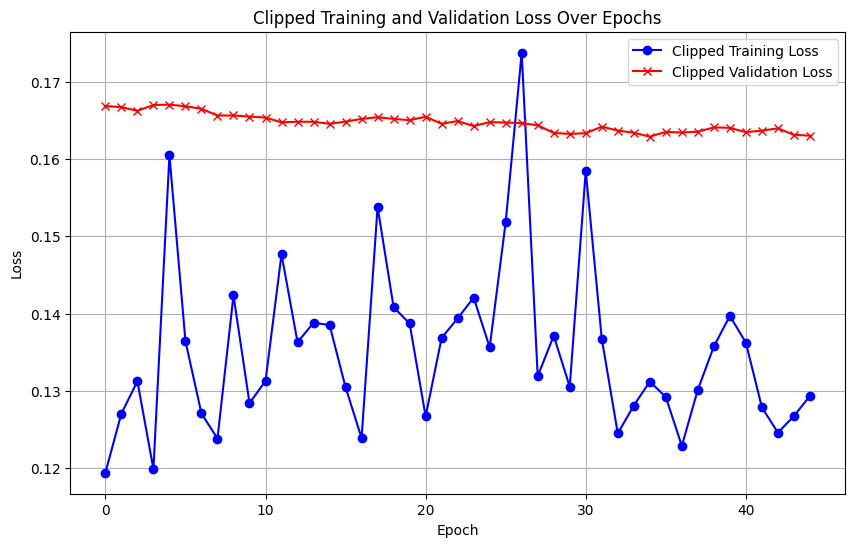

In [ ]:
import matplotlib.pyplot as plt

train_losses = trainer_result['train_loss']
val_losses = trainer_result['loss']  # Assuming 'loss' contains the validation losses

max_loss = 1  # Set a threshold for maximum loss to visualize

clipped_train_losses = [min(loss, max_loss) for loss in train_losses]
clipped_val_losses = [min(loss, max_loss) for loss in val_losses]

plt.figure(figsize=(10, 6))
plt.plot(clipped_train_losses, label='Clipped Training Loss', color='blue', marker='o')
plt.plot(clipped_val_losses, label='Clipped Validation Loss', color='red', marker='x')
plt.title('Clipped Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## ⭐ Evaluate

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

from torchvision.utils import save_image
from dataset import reconstruct_patched

def simple_micrograph_preprocessing(micrograph):
  micrograph_copy = micrograph.copy()
  micrograph_copy = (micrograph_copy-micrograph.mean()+2.5*micrograph.std())/5/micrograph.std()
  micrograph_copy[micrograph_copy<0]=0
  micrograph_copy[micrograph_copy>1]=1
  return micrograph_copy

!mkdir {RESULT_DIR}/Each_ckpt

mkdir: cannot create directory ‘/content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/Each_ckpt’: File exists


### ⏭ Test score for all saved checkpoint.

In [ ]:
# Check the last five best epochs
model = model_post
checkpoint_paths = [path for path in os.listdir(RESULT_DIR) if '.pt' in path]
for checkpoint_path in checkpoint_paths[-5:]:
  state_dict_path = f"{RESULT_DIR}/{checkpoint_path}"
  state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))
  model.load_state_dict(state_dict, strict=False)
  model.eval()
  print("\nLoad model at: ", state_dict_path)
  #trainer = CryoEMTrainerWithScheduler(model, train_dataset, criterion, optimizer, device,
  #              num_classes=NUM_CLASSES,
  #              lr_scheduler=scheduler, patience=ES_PATIENCE)
  #result = trainer.evaluate(test_loader)
  model.to(DEVICE)
  model.eval()
  mini_batch_size = 9  # Number of patches to process at once
  with torch.no_grad():
    idx, (test_image, _, grid, _) = next(enumerate(test_dataset))
    inputs = test_image.to(DEVICE)
    num_batches = (inputs.size(0) + mini_batch_size - 1) // mini_batch_size
    patched_outputs = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * mini_batch_size
        end_idx = min(start_idx + mini_batch_size, inputs.size(0))
        patch_input = inputs[start_idx:end_idx].to(DEVICE)
        output = model(patch_input)['out']
        patched_outputs.append(output.cpu())  # Move to CPU to conserve GPU memory

        del patch_input
        torch.cuda.empty_cache()
    outputs = torch.cat(patched_outputs).to(DEVICE)  # Move to CPU to conserve GPU memory
    del patched_outputs
    torch.cuda.empty_cache()
    preds = outputs.argmax(dim=1).unsqueeze(1).cpu().detach()  # Now preds will have shape [81, 1, 512, 512]

    ## Plotting
    micrograph = np.load(f"{IMAGE_DIR}/val/{val_filenames[idx][:-4]}.npy")
    label_path = f"{LABEL_DIR}/{val_filenames[idx][:-4]}.png"


    micrograph_copy = simple_micrograph_preprocessing(micrograph)
    #crop_amount = 128  # Amount cropped from each side of the label image
    mic_width, mic_height = micrograph_copy.shape[1], micrograph_copy.shape[0]

    # Calculate starting and ending indices for cropping the micrograph
    #start_x = int((mic_width - 3840) / 2)
    #end_x = start_x + 3840
    #start_y = int((mic_height - 3840) / 2)
    #end_y = start_y + 3840

    # Crop the micrograph
    cropped_micrograph = micrograph_copy
    pred_image = reconstruct_patched(preds, grid).float()

    _,ax = plt.subplots(figsize=(12, 12))
    ax.imshow(cropped_micrograph, cmap='gray')
    ax.imshow(pred_image.squeeze(), cmap='inferno', alpha=0.4)
    plt.show()
    ##

    filename = f"{os.path.splitext(checkpoint_path)[0]}.png"
    pred_path = os.path.join(RESULT_DIR, "Each_ckpt", filename)
    save_image(pred_image, pred_path)

Output hidden; open in https://colab.research.google.com to view.

### ✅ Testing

In [ ]:
model = model_post
CHECKPOINT_PATH = "/content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint35.pt" # @param {type:"string"}
state_dict_path = CHECKPOINT_PATH
state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()
print("Load model at: ", state_dict_path)

<ipython-input-18-62413f56ba05>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location=torch.device(DEVICE))


Load model at:  /content/drive/MyDrive/research_xs/results/10081_test/unet_eb5_dice_postcrf/checkpoint35.pt


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
test_dir = os.path.join(IMAGE_DIR, 'test')
test_filenames = np.loadtxt(f"{IMAGE_DIR}/test_filenames.txt", dtype=str)
np.random.seed(24)
selected_filenames = np.random.choice(test_filenames, size=6, replace=False)
print(selected_filenames)
test_dataset = MicrographDatasetEvery(image_dir=test_dir, label_dir=LABEL_DIR, filenames=selected_filenames, crop_size=CROP_SIZE)
test_loader = DataLoader(test_dataset, batch_size=None, shuffle=False, pin_memory=True)

['HCN1apo_1044_2xaligned.mrc' 'HCN1apo_0612_2xaligned.mrc'
 'HCN1apo_0437_2xaligned.mrc' 'HCN1apo_1007_2xaligned.mrc'
 'HCN1apo_0494_2xaligned.mrc' 'HCN1apo_0052_2xaligned.mrc']


In [ ]:
evaluator = CryoEMEvaluator(
    model=model, device=DEVICE, metrics=['AP','iou'],
    num_classes=NUM_CLASSES)
print("ConvCRF validation result:")
result = evaluator.evaluate(loader=val_loader)
print("ConvCRF test result:")
result = evaluator.evaluate(loader=test_loader)

ConvCRF validation result:
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
Iou by Class: [0.9291272 0.5687135]
Precision by Class: [0.97572947 0.6617879 ]
Recall by Class: [0.95110863 0.801734  ]
Accuracy by Class: [0.9351846 0.9351846]
F1_score by Class: [0.9632618  0.72506994]
ConvCRF test result:
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
torch.Size([81, 1, 512, 512])
Iou by Class: [0.9280603  0.59107685]
Precision by Class: [0.9680666  0.71560353]
Recall by Class: [0.9573689 0.7725554]
Accuracy by Class: [0.9348363 0.9348363]
F1_score by Class: [0.962688   0.74298966]
